In [14]:
test_acc_dict = {}

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
from tqdm.auto import tqdm

#Device, will be using a GPU on google Colab
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


In [104]:
#Configuration Stuff
DATA_DIR = "./data"
batch_size = 128
epochs = 50
lr = 1e-3
weight_decay = 1e-4
validation_ratio = 0.1
num_classes = 10 #for CIFAR-10 dataset
SEED = 42 # for reproducibility

torch.manual_seed(SEED)

BELOW IS FOR PRETRAINED MODEL DATASETS ONLY



In [61]:
#Transforms -- CIFAR is 32 x 32, ImageNet-style pretrained models have differnet Pixel sizes
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

#Explanation: we're trying to match the 224x224 pixel size of imageNet image, and as a result we apply some change in dimensions + normalization

In [5]:
# FOR PRETRAINED MODELS
#Read the CIFAR-10 Dataset
DATA_DIR = "./data"
full_train = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_tf)
test = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_tf)

#train/val split
val_size = int(len(full_train) * validation_ratio)
train_size = len(full_train) - val_size
train, val_set = random_split(full_train, [train_size, val_size])

val_set.dataset.transform = test_tf

#Dataloaders (iterable wrapper)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

BELOW IS FOR MANUAL CNN AND MLP ONLY

In [105]:
# FOR MANUAL CNN and MLP
train_tf = transforms.ToTensor()
test_tf  = transforms.ToTensor()

full_train = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_tf)
test = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_tf)

val_size = int(len(full_train) * validation_ratio)
train_size = len(full_train) - val_size
train, val_set = random_split(full_train, [train_size, val_size])

val_set.dataset.transform = test_tf

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test, batch_size=batch_size, shuffle=False)

**From the below 8 cells, make sure the run ONLY the one that you would like to train on the CIFAR-10 set for benchmarking!**

Make Sure to rerun the kernel from the second cell for each model achitecture!
(First cell includes the dictionary)


---


---



In [ ]:
#Now load the pretrained ResNet-50 and replace the final output classification layer
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)
model = model.to(device)

#Freeze the backbone, since we're only doing feature extraction
for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

model_str = "ResNet50"

In [ ]:
#This will be the code for a ResNet-18 that also repalces the final output classification layer
weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)
model = model.to(device)

#Freeze the backbone, since we're only doing feature extraction
for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

model_str = "ResNet18"

In [ ]:
#Code for DenseNet-121
weights = models.DenseNet121_Weights.IMAGENET1K_V1
model = models.densenet121(weights=weights)
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)
model = model.to(device)

#Freeze the backbone, since we're only doing feature extraction
for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

model_str = "DenseNet121"

In [ ]:
#Code for VGG16
weights = models.VGG16_Weights.IMAGENET1K_V1
model = models.vgg16(weights=weights)
model.classifier[-1] = nn.Sequential(
    nn.Linear(model.classifier[6].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)
model = model.to(device)

# Freeze everything
for p in model.parameters():
    p.requires_grad = False

# Unfreeze ONLY the new head
for p in model.classifier[-1].parameters():
    p.requires_grad = True

model_str = "VGG16"

In [ ]:
#Code for VGG19
weights = models.VGG19_Weights.IMAGENET1K_V1
model = models.vgg19(weights=weights)
model.classifier[-1] = nn.Sequential(
    nn.Linear(model.classifier[6].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)
model = model.to(device)

# Freeze everything
for p in model.parameters():
    p.requires_grad = False

# Unfreeze ONLY the new head
for p in model.classifier[-1].parameters():
    p.requires_grad = True
model_str = "VGG19"

In [ ]:
#Code for ConvNeXt-Tiny
weights = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1
model = models.convnext_tiny(weights=weights)
model.classifier[2] = nn.Sequential(
    nn.Linear(model.classifier[2].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)
model = model.to(device)

# Freeze everything
for p in model.parameters():
    p.requires_grad = False

# Unfreeze ONLY the new head
for p in model.classifier[-1].parameters():
    p.requires_grad = True
model_str = "ConvNeXt-Tiny"

In [70]:
# Code for a manual CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )


        self.classifier = nn.Sequential(
            nn.Linear(128*4*4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CNN().to(device)
model_str = "Manual CNN"

In [106]:
dropout = 0.2
# Code for a manual MLP
class MLP(nn.Module):
    def __init__(self):
      super(MLP, self).__init__()

      self.net = nn.Sequential(
            nn.Flatten(),  # (B, 3, 32, 32) -> (B, 3072)

            nn.Linear(3072, 2048),
            nn.BatchNorm1d(2048),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(256, num_classes),  # logits: (B, 10)
        )

    def forward(self, x):
        return self.net(x)


model = MLP().to(device)
model_str = "Manual MLP"

In [107]:
# Loss + Optimizer on the trainable params
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p:p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)

In [108]:
from torch.nn.modules import loss
#Training loop
def training_loop(dataloader, model, optimizer, loss_fn):
  model.train()
  total_loss = 0.0;

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    logits = model(X)
    loss = loss_fn(logits, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

#Validation Loop, on validation data
def testing_loop(dataloader, model, loss_fn):
  model.eval()
  total_loss = 0.0
  correct = 0.0
  total = 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      logits = model(X)
      pred = logits.argmax(1)
      loss = loss_fn(logits, y)

      total_loss += loss.item()
      correct += (pred == y).type(torch.float).sum().item()
      total += y.size(0)

  return 100 * correct / total, total_loss / len(dataloader)


In [109]:
train_losses = []
val_losses = []
val_accs = []

best_val_acc = -1.0 #baseline value
best_state = copy.deepcopy(model.state_dict())

for epoch in range(epochs):
  # 1) train for one epoch
  train_loss = training_loop(train_loader, model, optimizer, criterion)

  # 2) Validate, without using test set
  val_acc, val_loss = testing_loop(val_loader, model, criterion)

  train_losses.append(train_loss)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

  # 3) save best model by validation accuracy
  if val_acc > best_val_acc:
    best_val_acc = val_acc
    best_state = copy.deepcopy(model.state_dict())

  # print occasionally
  if epoch % 1 == 0:
        print(f"Epoch {epoch+1:02d}/{epochs} | "
              f"train loss {train_loss:.4f} | "
              f"val acc {val_acc:.2f}% val loss {val_loss:.4f} | "
              f"best val acc {best_val_acc:.2f}%")

  scheduler.step()
# ------ For loop is done ---------- #

# 4) load the best model
model.load_state_dict(best_state)

# 5) final evaluation on TEST SET for model comparisons
test_acc, test_loss = testing_loop(test_loader, model, criterion)
print(f"\nFINAL TEST | acc {test_acc:.2f}% | loss {test_loss:.4f}")




Epoch 01/50 | train loss 1.7687 | val acc 46.20% val loss 1.5564 | best val acc 46.20%
Epoch 02/50 | train loss 1.5081 | val acc 48.92% val loss 1.4464 | best val acc 48.92%
Epoch 03/50 | train loss 1.3870 | val acc 49.52% val loss 1.4292 | best val acc 49.52%
Epoch 04/50 | train loss 1.2988 | val acc 51.62% val loss 1.3740 | best val acc 51.62%
Epoch 05/50 | train loss 1.2278 | val acc 52.56% val loss 1.3403 | best val acc 52.56%
Epoch 06/50 | train loss 1.1613 | val acc 53.48% val loss 1.3120 | best val acc 53.48%
Epoch 07/50 | train loss 1.1034 | val acc 50.32% val loss 1.4046 | best val acc 53.48%
Epoch 08/50 | train loss 1.0522 | val acc 53.20% val loss 1.3347 | best val acc 53.48%
Epoch 09/50 | train loss 1.0003 | val acc 48.24% val loss 1.6052 | best val acc 53.48%
Epoch 10/50 | train loss 0.9544 | val acc 54.00% val loss 1.3269 | best val acc 54.00%
Epoch 11/50 | train loss 0.9114 | val acc 54.68% val loss 1.3497 | best val acc 54.68%
Epoch 12/50 | train loss 0.8631 | val acc 5

In [110]:
#Save the final test accuracy in a dictionary for comparison later
test_acc_dict[model_str] = test_acc

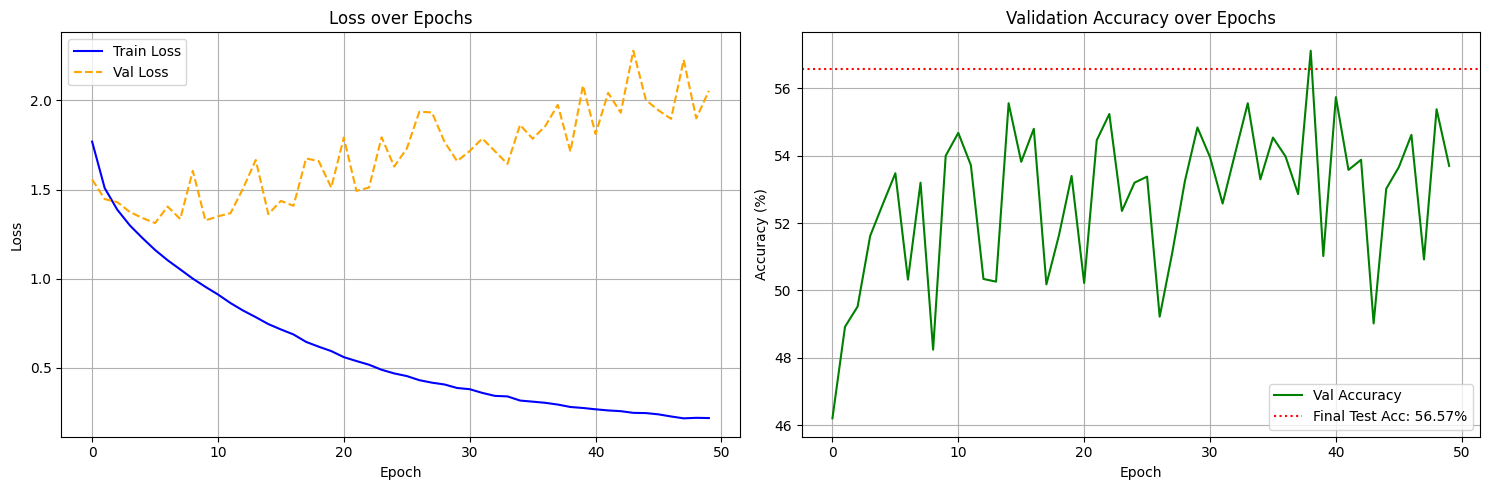

In [111]:
# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# --- Plot 1: Training & Validation Loss ---
ax1.plot(train_losses, label='Train Loss', color='blue', linestyle='-')
ax1.plot(val_losses, label='Val Loss', color='orange', linestyle='--')
ax1.set_title('Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# --- Plot 2: Validation Accuracy ---
ax2.plot(val_accs, label='Val Accuracy', color='green')
ax2.axhline(y=test_acc, color='red', linestyle=':', label=f'Final Test Acc: {test_acc:.2f}%')
ax2.set_title('Validation Accuracy over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipython-input-106553774.py:14: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('Test Accuracy ($\%$)', fontsize=12)
/tmp/ipython-input-106553774.py:23: SyntaxWarning: invalid escape sequence '\%'
  plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'${yval:.2f}\%$',


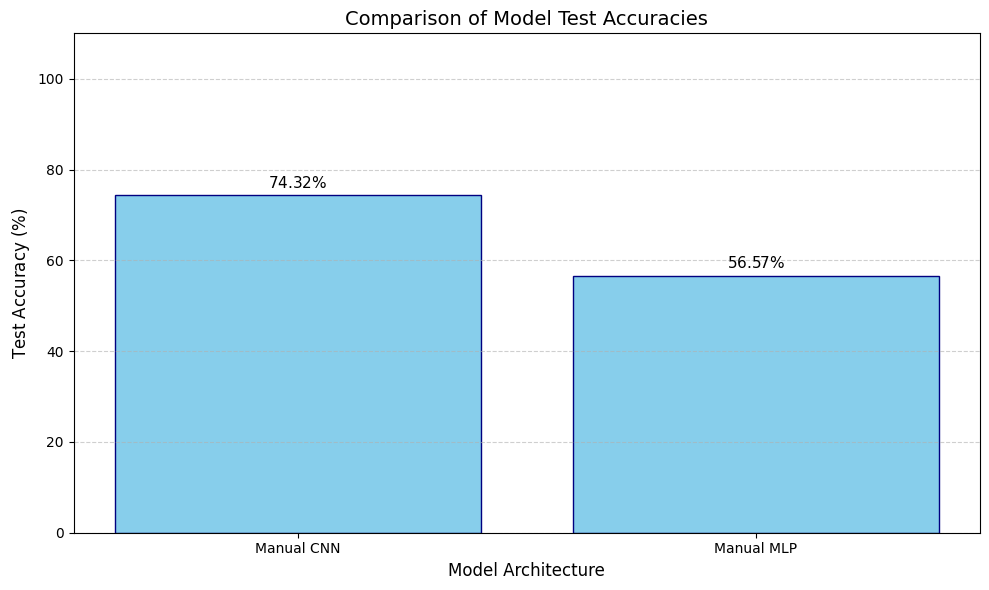

In [112]:
# 1. Sort the results from highest to lowest accuracy
# This makes the graph much easier to read at a glance
sorted_results = dict(sorted(test_acc_dict.items(), key=lambda item: item[1], reverse=True))

models = list(sorted_results.keys())
accuracies = list(sorted_results.values())

# 2. Setup the figure
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color='skyblue', edgecolor='navy')

# 3. Add formatting, labels, and title
plt.xlabel('Model Architecture', fontsize=12)
plt.ylabel('Test Accuracy ($\%$)', fontsize=12)
plt.title('Comparison of Model Test Accuracies', fontsize=14)

# Set the y-axis limit slightly above 100 to make room for labels
plt.ylim(0, 110)

# 4. Add the exact accuracy value on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'${yval:.2f}\%$',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 5. Optional: Add a subtle grid for better visual alignment
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()